In [2]:
import vip 
import numpy as np
import matplotlib.pyplot as plt
from myds9 import ds9
plots = vip.var.pp_subplots
plot_histo = vip.stats.frame_histo_stats
%matplotlib inline

RO.DS9 unusable: [Error 2] The system cannot find the file specified
vipDS9 class that controls DS9 will not be available 

---------------------------------------------------
         oooooo     oooo ooooo ooooooooo.          
          `888.     .8'  `888' `888   `Y88.        
           `888.   .8'    888   888   .d88'        
            `888. .8'     888   888ooo88P'         
             `888.8'      888   888                
              `888'       888   888                
               `8'       o888o o888o               
---------------------------------------------------
     Vortex Image Processing pipeline v0.4.2
---------------------------------------------------
Please cite Gomez Gonzalez et al. 2016 (in prep.)  
whenever you publish data reduced with VIP. Thanks.


We are going to make assumption on the data set, first raw approach
- The noise is here Gaussian and white, iid in time and space (won't be true in the end)
- We will first consider a single companion without the star at the center
- single target then multi target
- single threshold for detection

We thus have frames $I$ such that $I = Ap + w$ where $w$ is a white noise or variance $\sigma^2$

Assuming these, we can estimate that by removing the planet's supposed position from the frames, we will obtain frame with the most likely independant gaussian distribution. We thus want to maximize the following :

$$ f(r_0,A)  = \prod_{(i,j)} \prod_k \frac{1}{\sigma_{i,j}\sqrt{2\pi} } exp \bigg(-\frac{|I_{i,j,k}-A p_{i,j,k}(r_0) |^2}{2\sigma^2_{i,j}}\bigg)$$
Where 
- $r_0$ and $A$ and the variables we can look for, that is respectivelly, the original position of the planet (some $i*$,$j*$), and its intensity level
- $(i,j)$ are the coordinates on a frame
- $k$ the index of the frame
- $I$ the set of frames
- $I_{i,j,k}$ is the pixel (i,j) of frame $k$
- $p$ is the set of frames with only the planet in it
- $p_{i,j,k}$ is the pixel (i,j) of the planet frame $k$
- $\sigma^2_{i,j}$ is the variance of noise on pixel ${i,j}$ (computed from the data)

Assuming this, we can simplify our maximization function. First we can abandon the first fraction term as it will not be vary with different $r_0$ and $A$. We can also rewrite this as an exponential of sum, that is 
$$
f(r_0,A)  \propto exp \bigg( \sum_{(i,j)} \sum_k -\frac{(I_{i,j,k}-A p_{i,j,k}(r_0) )^2}{2\sigma^2_{i,j}}\bigg)
$$

Furthermore, as we are intereseted in the max arguments, we can also maximize its logarithm, thus working with log likelihood function 
$$
lf (r_0,A) = - \sum_{(i,j)} \sum_k \frac{(I_{i,j,k}-A p_{i,j,k}(r_0) )^2}{2\sigma^2_{i,j}}
$$

We now have a function with two variables to determine, But one can see that the optimal $A$ for a given $r_0$ will nullity the derivative of lf. As such, we can estimate 

$$
\hat{A}(r_0) = \frac{\sum_{(i,j)} \sum_k (I_{i,j,k}\cdot p_{i,j,k}(r_0))/ \sigma^2_{i,j}}{\sum_{(i,j)} \sum_k (p^2_{i,j,k}(r_0))/ \sigma^2_{i,j}}
$$

By injecting the estimator of $A$ inside the expression of $lf$ we can find $lf2$ such that
$$
lf2(r_0,A) = - \sum_{(i,j)} \sum_k \frac{I^2_{i,j,k}}{2\sigma^2_{i,j}} + \frac{\bigg( \sum_{(i,j)} \sum_k (I_{i,j,k}\cdot p_{i,j,k}(r_0))/ \sigma^2_{i,j}\bigg)^2}{2\sum_{(i,j)} \sum_k (p^2_{i,j,k}(r_0))/ \sigma^2_{i,j}}
$$

-> We can also comptue the variance of $\hat{A}(r_0)$ by using $I = Ap+w$ and the $iid$ hypothesis on $w$. We obtain  (see sheet) 
$$
\sigma^2(\hat{A}(r_0)) = (\sum_{(i,j)} \sum_k p^2_{i,j,k}(r_0)/\sigma^2_{i,j} )^{-1}
$$

This allows us to define the $SNR$ as a sensitivity mesure  : $\frac{Signal}{RMS\ noise}$


$$\Rightarrow \ \ \ \ SNR = \frac{\hat{A}(r_0)}{\sigma(\hat{A}(r_0))} = \frac{\sum_{(i,j)} \sum_k (I_{i,j,k}\cdot p_{i,j,k}(r_0))/ \sigma^2_{i,j}}{ \sqrt{\sum_{(i,j)} \sum_k (p^2_{i,j,k}(r_0))/ \sigma^2_{i,j}} }$$


One can see that $lf2 = \frac{SNR^2}{2} + Constant$. This means that finding the optimal $r_0$ for SNR is equivalent to finding the optimal $r_0$ for lf  we can thus maximize SNR and use a threshold detection of5 $\sigma$ to have a high confidence of discerning the planet from the background  according to the Rose criterion.  . The method will compute SNR for all $r_0$ in the frame and return SNR , $\hat{A}$ and the variance matrices.

This needs to be adapted afterwards on actual data as the distribution varies radially.

In [3]:
#load sample
pp = '../Data/vip_datasets/naco_betapic_small/planet_only_crop.fits'
pp2 = '../Data/vip_datasets/naco_betapic_big/img_bpic_batch1_rec_dc.fits'
PSF = '../Data/vip_datasets/naco_betapic_big/fake_companion_naco_Lp_apo_l27_norm.fits'
planet = vip.fits.open_fits(pp)
p2,ang = vip.fits.open_adicube(pp2)
psf = vip.fits.open_fits(PSF)
del pp2,p2,PSF
pxscale_naco = 0.027190


Fits HDU:0 data successfully loaded. Data shape: [612,100,100]

Fits HDU:0 data successfully loaded. Data shape: [612,300,300]

Fits HDU:1 data successfully loaded. Data shape: [612]

Fits HDU:0 data successfully loaded. Data shape: [39,39]


In [4]:
#create new data
planet_noise = np.copy(planet) + np.random.normal(0,200,size=planet.shape)


In [7]:
import time

In [5]:
SNR_map = np.zeros(planet.shape[1:])
A_map = np.zeros(planet.shape[1:])
sigma_map = np.zeros(planet.shape[1:])
# pre data
from my_mle import mle_gaussian
ceny,cenx= vip.var.frame_center(planet[0])
var_mat = np.var(planet_noise,axis=0)

In [ ]:
t  = time.clock()
t_old = t
for j in xrange(planet.shape[1]):
    for i in xrange(planet.shape[2]):
        A,sigma,SNR = mle_gaussian(planet_noise,ang,cenx,ceny,i,j,1,psf,pxscale_naco,var_mat)
        #mle_gaussian(planet_noise,ang,cenx,ceny,pos_x = i*1.0,pos_y = j*1.0,amplitude=1,psf,pxscale_naco, var_mat)
        SNR_map[j,i] = SNR
        A_map[j,i] = A
        sigma_map[j,i] = sigma
    t_temp = time.clock()-t_old
    t_old = time.clock()
    print 'Round j: '+str(j)+' in '+str(t_temp)+' s.'

t_final = time.clock()-t
print 'time elapsed : '+str(t_final)

Let's have a look at the SNR, Amplitude found and actual position of the planet.

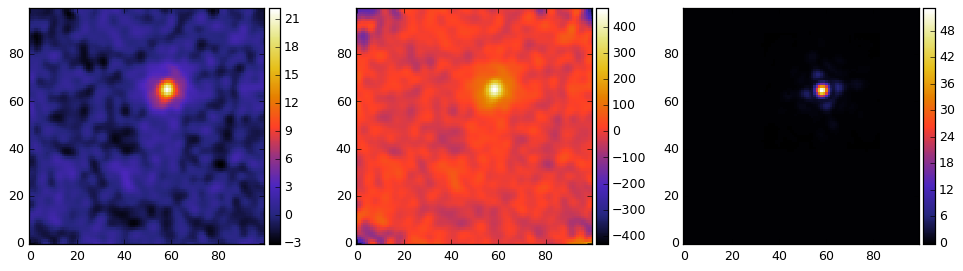

In [20]:
plots(SNR_map,A_map,planet[0],colorb=True)


We now test with 2 planets  and a noise with std of 200. The position/flevel of each plante is the following : 
- 58, 65  400
- 22, 79  700

In [10]:
pp = '../Data/vip_datasets/naco_betapic_small/2_planets_crop.fits'
planet2 = vip.fits.open_fits(pp)


Fits HDU:0 data successfully loaded. Data shape: [612,100,100]


In [11]:
planet2_noise = np.copy(planet2) + np.random.normal(0,200,size=planet.shape)

In [12]:
SNR_map2 = np.zeros(planet.shape[1:])
A_map2 = np.zeros(planet.shape[1:])
sigma_map2 = np.zeros(planet.shape[1:])
# pre data
#from my_mle import mle_gaussian
ceny,cenx= vip.var.frame_center(planet2[0])
var_mat2 = np.var(planet2_noise,axis=0)

In [ ]:
t  = time.clock()
t_old = t
for j in xrange(planet.shape[1]):
    for i in xrange(planet.shape[2]):
        A,sigma,SNR = mle_gaussian(planet2_noise,ang,cenx,ceny,i,j,1,psf,pxscale_naco,var_mat2)
        #mle_gaussian(planet_noise,ang,cenx,ceny,pos_x = i*1.0,pos_y = j*1.0,amplitude=1,psf,pxscale_naco, var_mat)
        SNR_map2[j,i] = SNR
        A_map2[j,i] = A
        sigma_map2[j,i] = sigma
    t_temp = time.clock()-t_old
    t_old = time.clock()
    print 'Round j: '+str(j)+' in '+str(t_temp)+' s.'

t_final = time.clock()-t
print 'time elapsed : '+str(t_final)

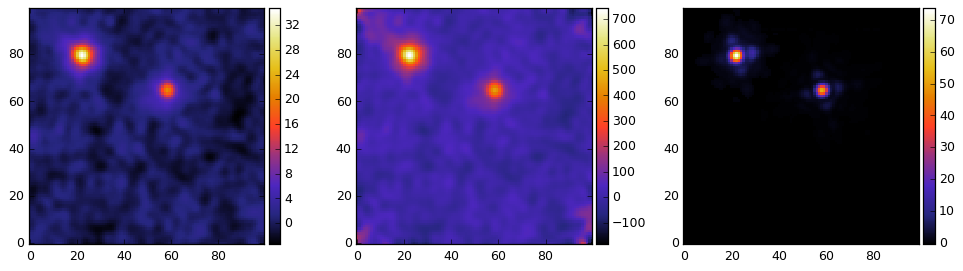

In [21]:
plots(SNR_map2,A_map2,planet2[0],colorb=True)

We now test with 3 planets  and a noise with std of 200. The position/flevelof each plante is the following : 
- 58, 65  400
- 40, 40  400
- 22, 79  350

In [14]:
pp = '../Data/vip_datasets/naco_betapic_small/3_planets_crop.fits'
planet3 = vip.fits.open_fits(pp)


Fits HDU:0 data successfully loaded. Data shape: [612,100,100]


In [15]:
planet3_noise = np.copy(planet3) + np.random.normal(0,200,size=planet.shape)

In [16]:
SNR_map3 = np.zeros(planet.shape[1:])
A_map3 = np.zeros(planet.shape[1:])
sigma_map3 = np.zeros(planet.shape[1:])
# pre data
#from my_mle import mle_gaussian
ceny,cenx= vip.var.frame_center(planet3[0])
var_mat3 = np.var(planet3_noise,axis=0)

In [ ]:
t  = time.clock()
t_old = t
for j in xrange(planet.shape[1]):
    for i in xrange(planet.shape[2]):
        A,sigma,SNR = mle_gaussian(planet3_noise,ang,cenx,ceny,i,j,1,psf,pxscale_naco,var_mat3)
        #mle_gaussian(planet_noise,ang,cenx,ceny,pos_x = i*1.0,pos_y = j*1.0,amplitude=1,psf,pxscale_naco, var_mat)
        SNR_map3[j,i] = SNR
        A_map3[j,i] = A
        sigma_map3[j,i] = sigma
    t_temp = time.clock()-t_old
    t_old = time.clock()
    print 'Round j: '+str(j)+' in '+str(t_temp)+' s.'

t_final = time.clock()-t
print 'time elapsed : '+str(t_final)

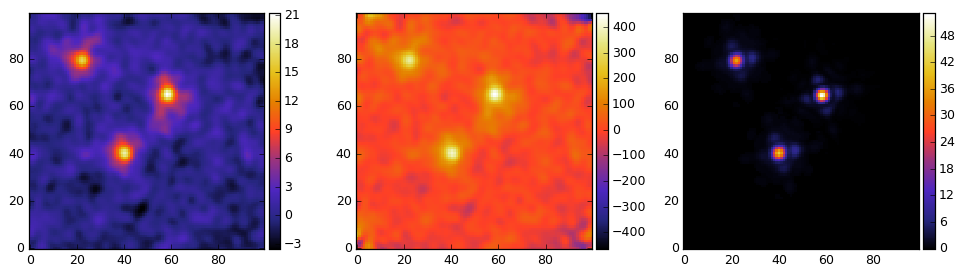

In [24]:
plots(SNR_map3,A_map3,planet3[0],colorb=True)

In [47]:
# no noise
SNR_map4 = np.zeros(planet.shape[1:])
A_map4 = np.zeros(planet.shape[1:])
sigma_map4 = np.zeros(planet.shape[1:])
# pre data
#from my_mle import mle_gaussian
ceny,cenx= vip.var.frame_center(planet[0])
var_mat4 = np.var(planet,axis=0)

In [ ]:
t  = time.clock()
t_old = t
for j in xrange(planet.shape[1]):
    for i in xrange(planet.shape[2]):
        A,sigma,SNR = mle_gaussian(planet,ang,cenx,ceny,i,j,1,psf,pxscale_naco,var_mat4)
        #mle_gaussian(planet_noise,ang,cenx,ceny,pos_x = i*1.0,pos_y = j*1.0,amplitude=1,psf,pxscale_naco, var_mat)
        SNR_map4[j,i] = SNR
        A_map4[j,i] = A
        sigma_map4[j,i] = sigma
    t_temp = time.clock()-t_old
    t_old = time.clock()
    print 'Round j: '+str(j)+' in '+str(t_temp)+' s.'

t_final = time.clock()-t
print 'time elapsed : '+str(t_final)

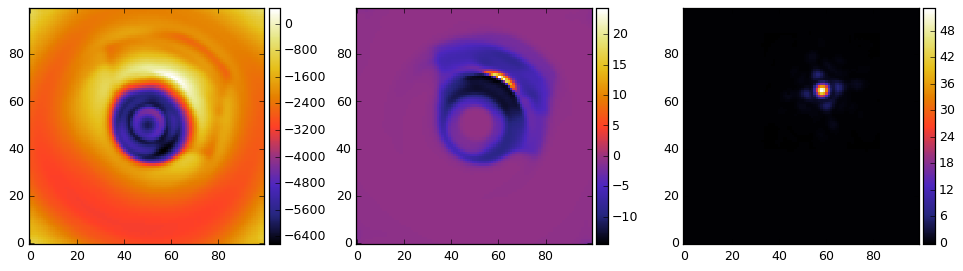

In [50]:
plots(SNR_map4,A_map4,planet[0],colorb=True)